In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
data = pd.read_csv(r"C:\Users\mdnih\Downloads\Steel_industry_data.csv\Steel_industry_data.csv",encoding='utf-8')

# displaying the first few features of the dataset and also to understand the structure of the dataset

print("\n",data.columns.tolist())
data.head()


 ['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type']


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Attribute Information:

Date Continuous - time data taken on the first of the month

Usage_kWh - Industry Energy Consumption Continuous kWh

Lagging Current - reactive power Continuous kVarh

Leading Current - reactive power Continuous kVarh

CO2 - Continuous ppm

NSM - Number of Seconds from midnight Continuous S

Week - status Categorical (Weekend (0) or a Weekday(1))

Day of week - Categorical Sunday, Monday : Saturday

Load Type - Categorical Light Load, Medium Load, Maximum Load



Dependent Variable (Target): Usage_kWh

Independent Variables (Features):

Lagging_Current_Reactive.Power_kVarh

Leading_Current_Reactive_Power_kVarh

CO2(tCO2)

Lagging_Current_Power_Factor

Leading_Current_Power_Factor

NSM

WeekStatus (Encoded)

Day_of_week (Encoded)

Load_Type (Encoded)

In [3]:
# To find the total number of records in the dataset
data.shape

(35040, 11)

In [6]:
duplicate_rows = data[data.duplicated(keep=False)]
print("Duplicate rows:")
print(duplicate_rows)

Duplicate rows:
Empty DataFrame
Columns: [date, Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2), Lagging_Current_Power_Factor, Leading_Current_Power_Factor, NSM, WeekStatus, Day_of_week, Load_Type]
Index: []


In [4]:
# initially categorize based on the type of the data
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# then we categorize based on unique values and content
binary_cols = [col for col in data.columns if data[col].nunique() == 2]
nominal_cols = ['Day_of_week']  # Based on prior knowledge of the data
categorical_cols = ['WeekStatus', 'Load_Type']  # Encoded but originally categorical
remaining_numerical = [col for col in numerical_cols if col not in binary_cols]
datetime_cols = data.select_dtypes(include=['datetime']).columns.tolist()

categorization = {
    "Binary": binary_cols,
    "Nominal": nominal_cols,
    "Categorical": categorical_cols,
    "Numerical": remaining_numerical,
    "Datetime": datetime_cols
}

# Convert the categorization dictionary to a DataFrame for display as a table
categorization_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in categorization.items()]))

categorization_df

,Binary,Nominal,Categorical,Numerical,Datetime
0,WeekStatus,Day_of_week,WeekStatus,Usage_kWh,NaN
1,NaN,NaN,Load_Type,Lagging_Current_Reactive.Power_kVarh,NaN
2,NaN,NaN,NaN,Leading_Current_Reactive_Power_kVarh,NaN
3,NaN,NaN,NaN,CO2(tCO2),NaN
4,NaN,NaN,NaN,Lagging_Current_Power_Factor,NaN
5,NaN,NaN,NaN,Leading_Current_Power_Factor,NaN
6,NaN,NaN,NaN,NSM,NaN


In [5]:
#let's convert the categorization dictionary to pair each feature with its categorized data type
features_and_types = []
for k, v in categorization.items():
    for i in v:
        if pd.notnull(i):
            features_and_types.append((i, k))

features_types_df_no_nan = pd.DataFrame(features_and_types, columns=['Feature Name', 'Data Type Categorized'])

features_types_df_no_nan


,Feature Name,Data Type Categorized
0,WeekStatus,Binary
1,Day_of_week,Nominal
2,WeekStatus,Categorical
3,Load_Type,Categorical
4,Usage_kWh,Numerical
5,Lagging_Current_Reactive.Power_kVarh,Numerical
6,Leading_Current_Reactive_Power_kVarh,Numerical
7,CO2(tCO2),Numerical
8,Lagging_Current_Power_Factor,Numerical
9,Leading_Current_Power_Factor,Numerical


In [6]:
summary_statistics = data.describe()
summary_statistics

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [7]:
# Check for missing values
missing_values = data.isnull().sum()

# Calculate the proportion of missing values
total_cells = np.product(data.shape)
total_missing = missing_values.sum()
proportion_missing = total_missing / total_cells

print(f"Number of missing values: {total_missing}")
print(f"Proportion of missing values: {proportion_missing:.2%}")

Number of missing values: 0
Proportion of missing values: 0.00%


In [8]:
# Example: Detect outliers using IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define bounds for what is considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((data < lower_bound) | (data > upper_bound)).sum()

In [9]:
outliers

CO2(tCO2)                                437
Day_of_week                                0
Lagging_Current_Power_Factor               1
Lagging_Current_Reactive.Power_kVarh    1059
Leading_Current_Power_Factor            8327
Leading_Current_Reactive_Power_kVarh    7759
Load_Type                                  0
NSM                                        0
Usage_kWh                                328
WeekStatus                                 0
date                                       0
dtype: int64

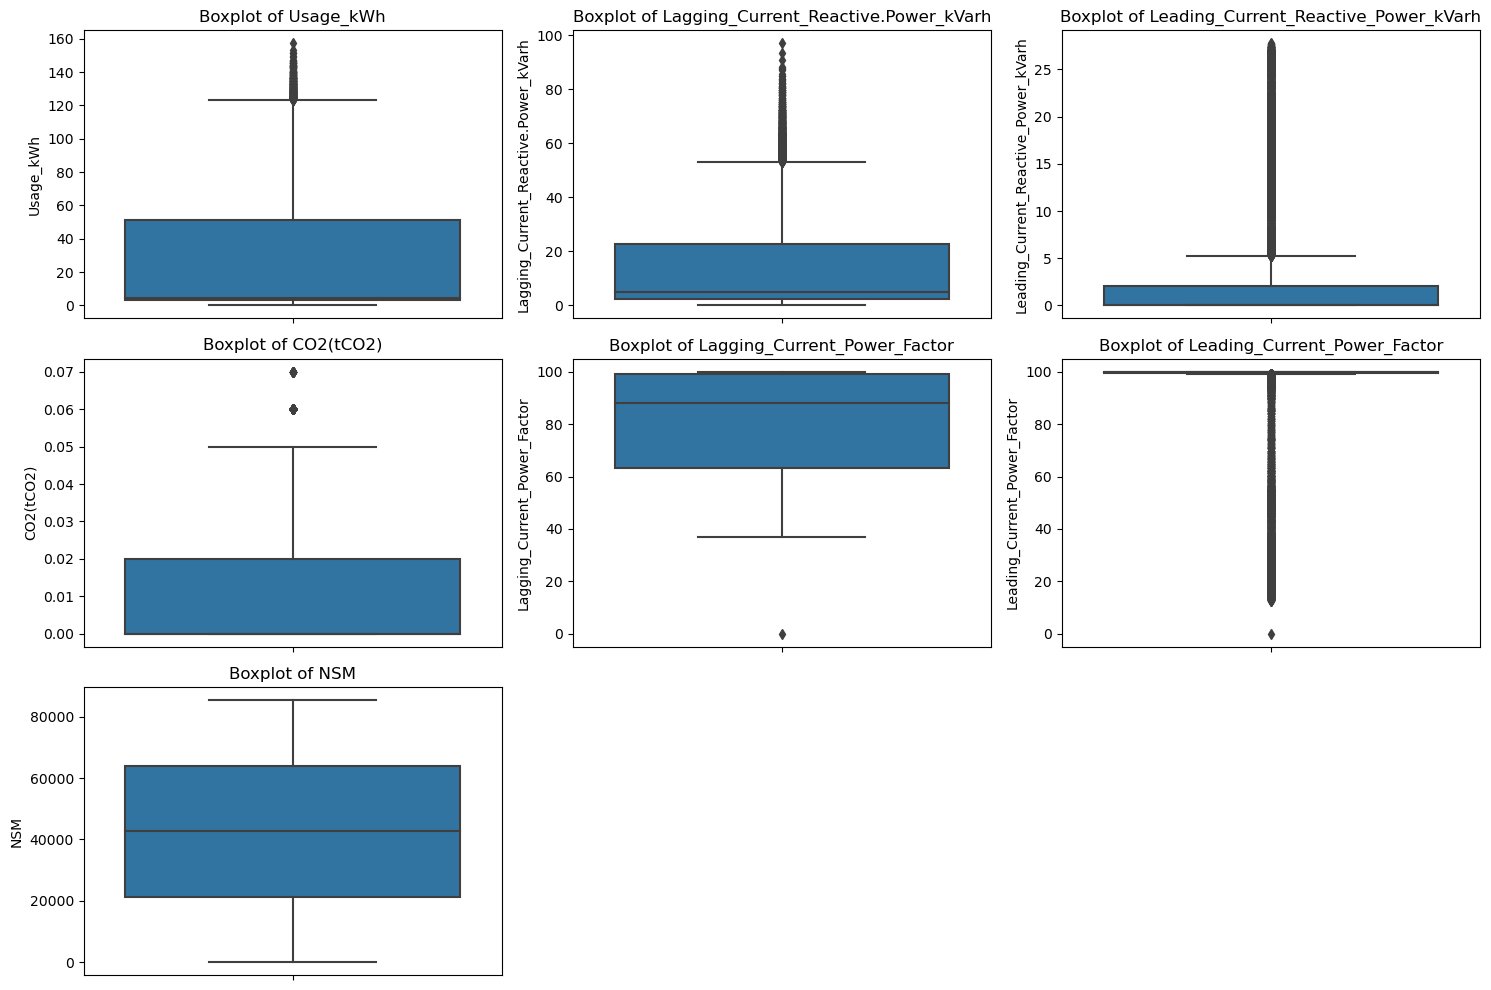

In [10]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Plot boxplots for each column
plt.figure(figsize=(15, 10))  # Adjust the size as needed
for i, col in enumerate(numerical_data.columns):
    plt.subplot(len(numerical_data.columns) // 3 + 1, 3, i + 1)
    sns.boxplot(y=col, data=numerical_data)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [11]:
# Capping at the 1st and 99th percentiles
for col in ['Usage_kWh', 'CO2(tCO2)']:
    lower_percentile = data[col].quantile(0.01)
    upper_percentile = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower_percentile, upper_percentile)

# Ensuring NSM is within the range 0 to 86400 (number of seconds in 24 hours)
data['NSM'] = np.clip(data['NSM'], 0, 86400)

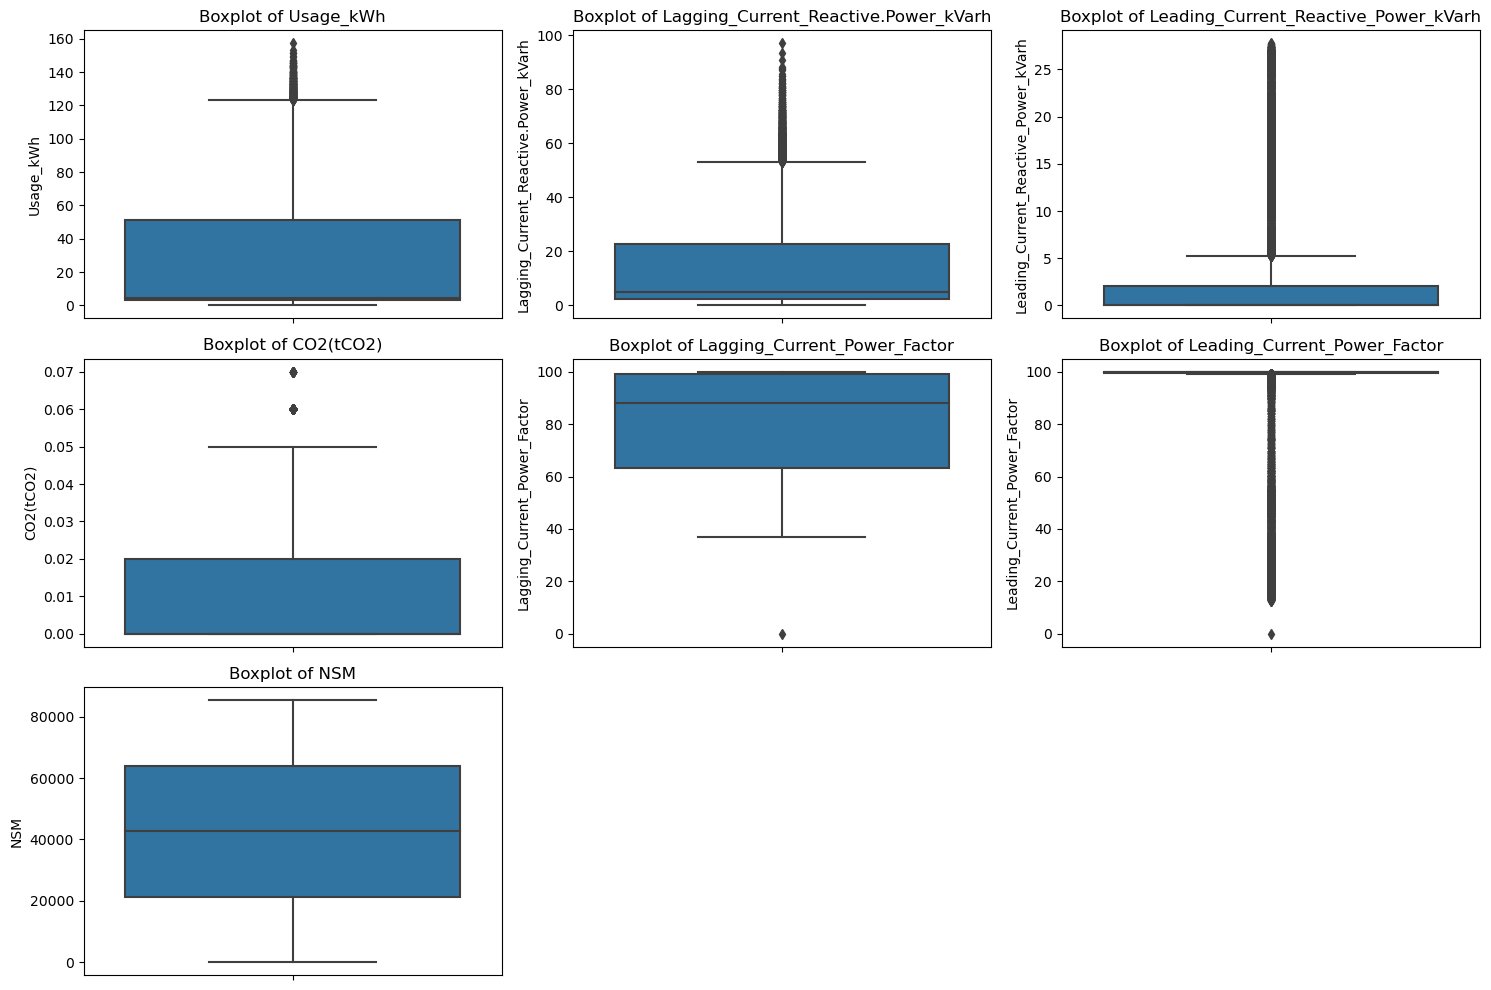

In [12]:
plt.figure(figsize=(15, 10))  # Adjust the size as needed
for i, col in enumerate(numerical_data.columns):
    plt.subplot(len(numerical_data.columns) // 3 + 1, 3, i + 1)
    sns.boxplot(y=col, data=numerical_data)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

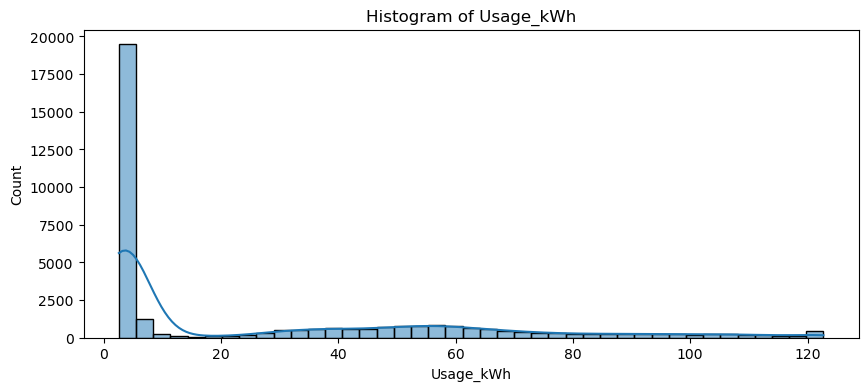

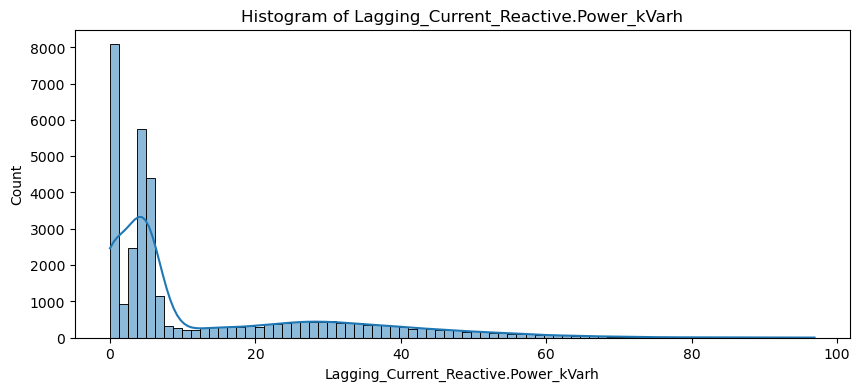

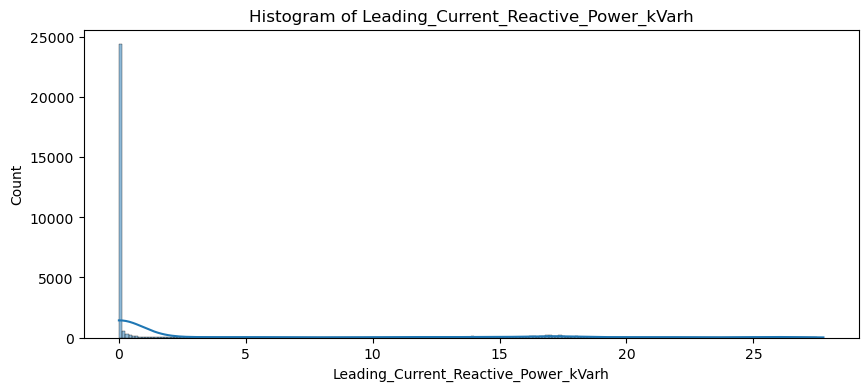

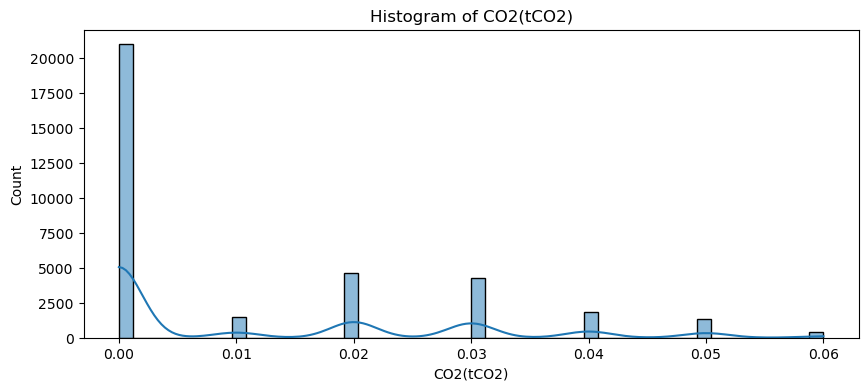

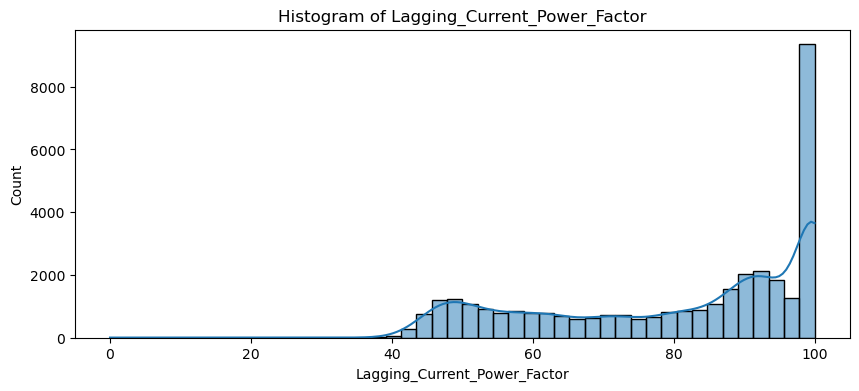

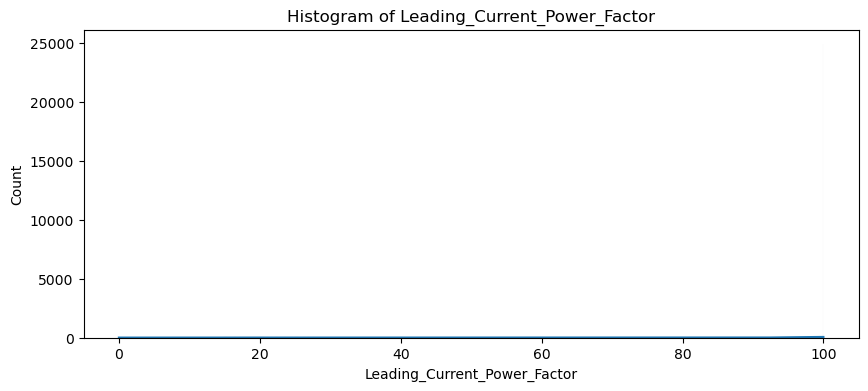

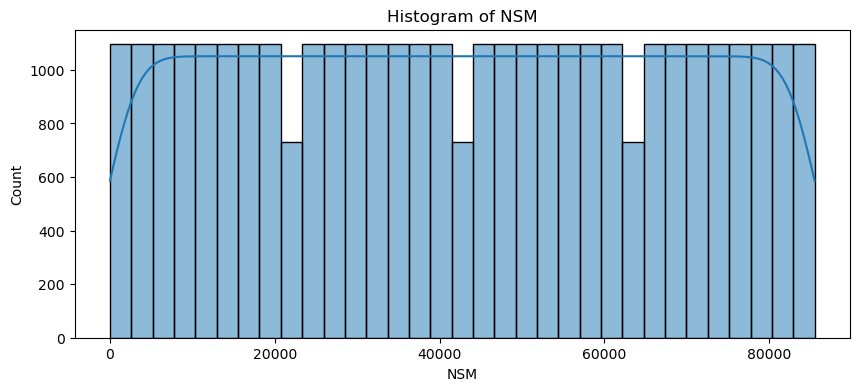

Positivity check (all values are >= 0):
Usage_kWh                               True
Lagging_Current_Reactive.Power_kVarh    True
Leading_Current_Reactive_Power_kVarh    True
CO2(tCO2)                               True
Lagging_Current_Power_Factor            True
Leading_Current_Power_Factor            True
NSM                                     True
dtype: bool

Skewness of numeric columns:
Usage_kWh                               1.161436
Lagging_Current_Reactive.Power_kVarh    1.437899
Leading_Current_Reactive_Power_kVarh    1.734314
CO2(tCO2)                               1.140444
Lagging_Current_Power_Factor           -0.606126
Leading_Current_Power_Factor           -1.511984
NSM                                     0.000000
dtype: float64


In [13]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
positivity = (numeric_data >= 0).all()
skewness = numeric_data.skew()

# Create histograms to visually assess skewness for each numeric column
for col in numeric_data.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

# Print the results
print(f"Positivity check (all values are >= 0):\n{positivity}\n")
print(f"Skewness of numeric columns:\n{skewness}")

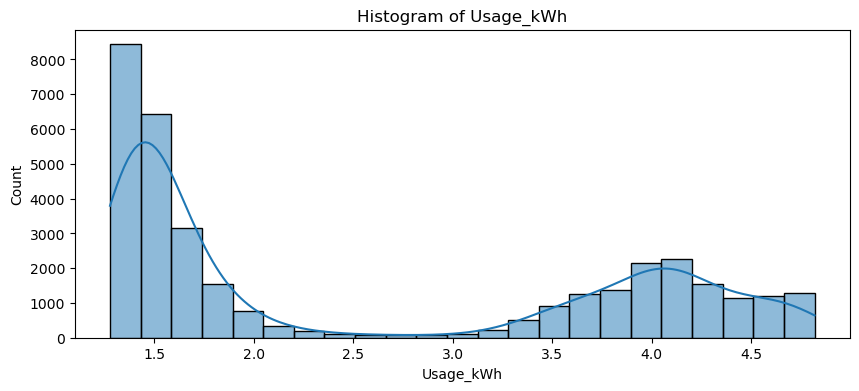

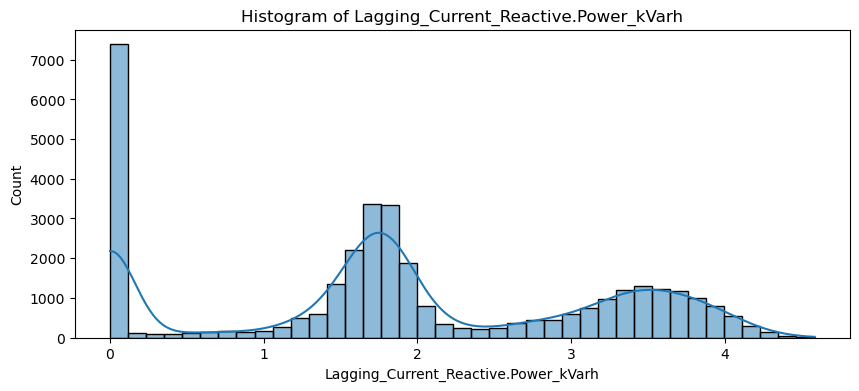

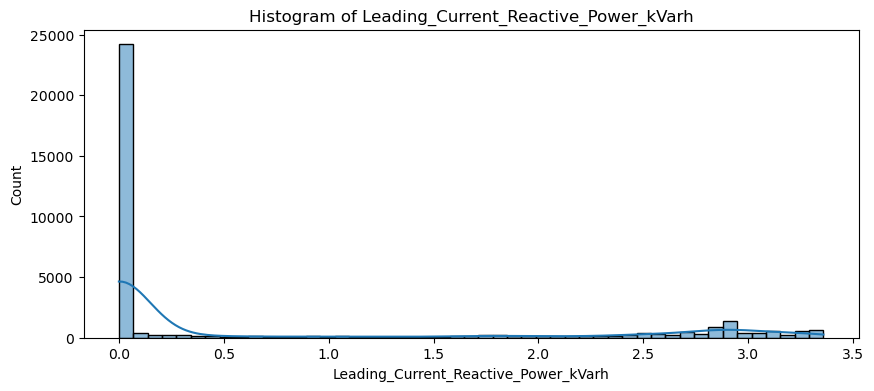

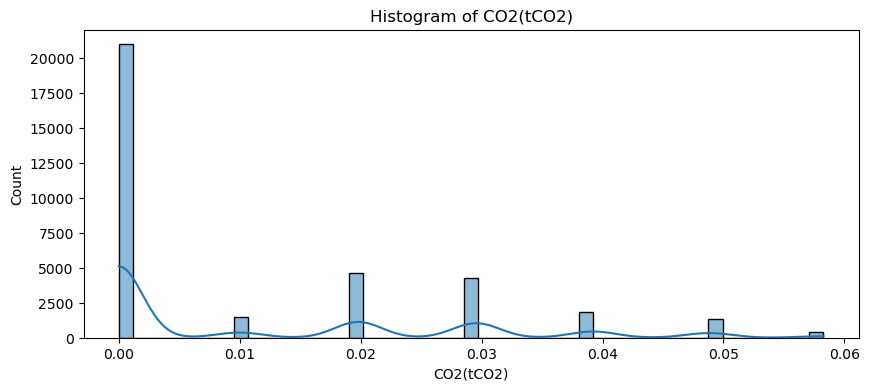

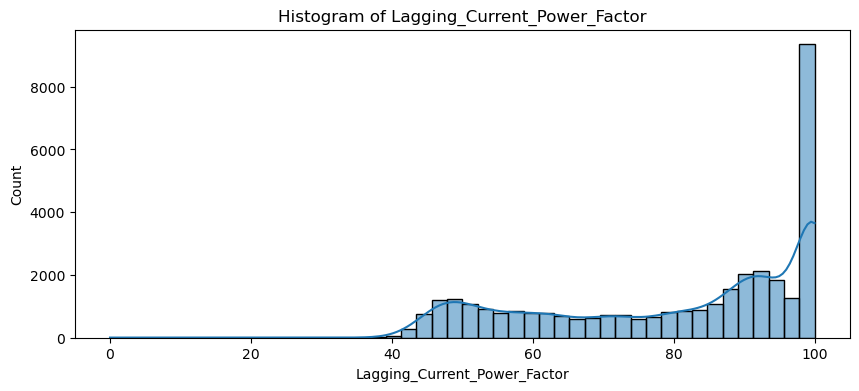

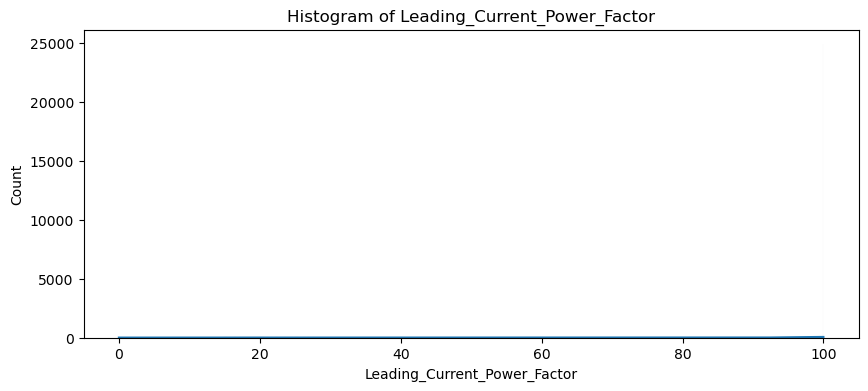

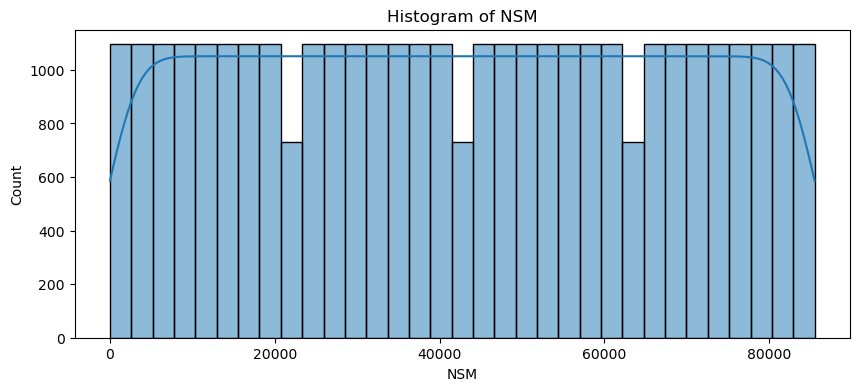

Positivity check (all values are >= 0):
Usage_kWh                               True
Lagging_Current_Reactive.Power_kVarh    True
Leading_Current_Reactive_Power_kVarh    True
CO2(tCO2)                               True
Lagging_Current_Power_Factor            True
Leading_Current_Power_Factor            True
NSM                                     True
dtype: bool

Skewness of numeric columns:
Usage_kWh                               0.487866
Lagging_Current_Reactive.Power_kVarh   -0.019717
Leading_Current_Reactive_Power_kVarh    1.266096
CO2(tCO2)                               1.120291
Lagging_Current_Power_Factor           -0.606126
Leading_Current_Power_Factor           -1.511984
NSM                                     0.000000
dtype: float64


In [14]:
data['Usage_kWh'] = np.log1p(data['Usage_kWh'])
data['Lagging_Current_Reactive.Power_kVarh'] = np.log1p(data['Lagging_Current_Reactive.Power_kVarh'])
data['Leading_Current_Reactive_Power_kVarh'] = np.log1p(data['Leading_Current_Reactive_Power_kVarh'])
data['CO2(tCO2)'] = np.log1p(data['CO2(tCO2)'])

numeric_data = data.select_dtypes(include=['float64', 'int64'])
positivity = (numeric_data >= 0).all()
skewness = numeric_data.skew()

# Create histograms to visually assess skewness for each numeric column
for col in numeric_data.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

# Print the results
print(f"Positivity check (all values are >= 0):\n{positivity}\n")
print(f"Skewness of numeric columns:\n{skewness}")

Low               4643
Moderate          4261
High              1834
Very Low          1512
Very High         1363
Extremely High     437
Name: CO2(tCO2)_binned, dtype: int64


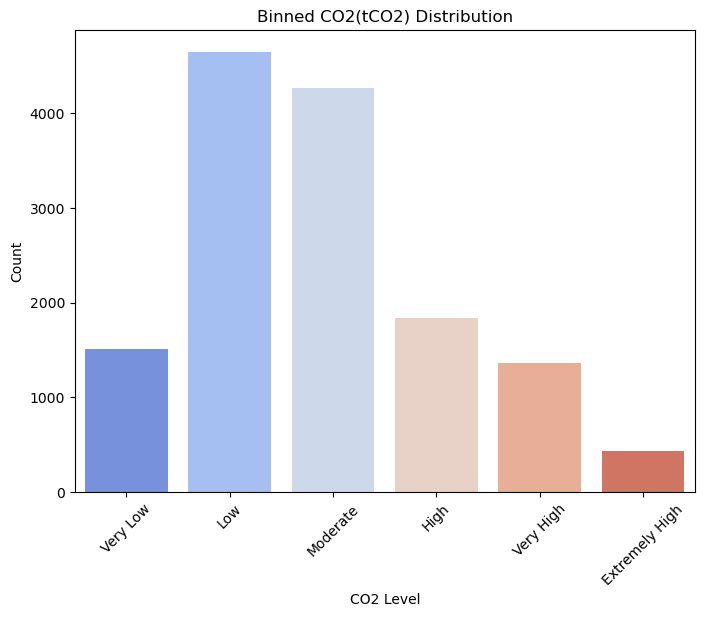

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins and labels
bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, np.inf]
bin_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extremely High']

# Bin the CO2 data
data['CO2(tCO2)_binned'] = pd.cut(data['CO2(tCO2)'], bins=bins, labels=bin_labels)
co2_binned_counts = data['CO2(tCO2)_binned'].value_counts()

# Print the distribution of the binned data
print(co2_binned_counts)

# Create a bar plot with annotations
plt.figure(figsize=(8, 6))
sns.barplot(x=co2_binned_counts.index, y=co2_binned_counts.values, order=bin_labels, palette='coolwarm')
plt.title('Binned CO2(tCO2) Distribution')
plt.xlabel('CO2 Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [16]:
# Final checks before modeling

# 1. Check for missing values
print("Missing values check:")
print(data.isnull().sum())

# 2. Check for categorical variables and transform them if needed
print("\nCategorical variables check:")
print(data.select_dtypes(include=['object']).head())

# 3. Check feature scales
print("\nFeature scales check (mean and standard deviation):")
print(data.describe().loc[['mean', 'std']])

# 4. Check for multicollinearity
print("\nMulticollinearity check:")
correlation_matrix = data.corr()
print(correlation_matrix)

# 5. Confirm data types
print("\nData types check:")
print(data.dtypes)

# 6. Confirm shape of the DataFrame
print("\nDataFrame shape check:")
print(data.shape)

# 7. Visualize the final DataFrame to ensure it looks as expected
print("\nDataFrame preview:")
print(data.head())


Missing values check:
date                                        0
Usage_kWh                                   0
Lagging_Current_Reactive.Power_kVarh        0
Leading_Current_Reactive_Power_kVarh        0
CO2(tCO2)                                   0
Lagging_Current_Power_Factor                0
Leading_Current_Power_Factor                0
NSM                                         0
WeekStatus                                  0
Day_of_week                                 0
Load_Type                                   0
CO2(tCO2)_binned                        20990
dtype: int64

Categorical variables check:
               date WeekStatus Day_of_week   Load_Type
0  01/01/2018 00:15    Weekday      Monday  Light_Load
1  01/01/2018 00:30    Weekday      Monday  Light_Load
2  01/01/2018 00:45    Weekday      Monday  Light_Load
3  01/01/2018 01:00    Weekday      Monday  Light_Load
4  01/01/2018 01:15    Weekday      Monday  Light_Load

Feature scales check (mean and standard deviation):


In [17]:
data = data.drop(columns=['CO2(tCO2)_binned'])

In [18]:
#lets encode the categorical features
categorical_cols = ['WeekStatus', 'Day_of_week', 'Load_Type']
ohe = OneHotEncoder()
encoded_categorical = ohe.fit_transform(data[categorical_cols]).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=ohe.get_feature_names(categorical_cols))

#lets drop the date column as it doesnt seem required for the further processing
data = data.drop(columns=categorical_cols + ['date'])
data = pd.concat([data.reset_index(drop=True), encoded_categorical_df.reset_index(drop=True)], axis=1)

#lets standardize the numerical values
scaler = StandardScaler()
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

data.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekday,WeekStatus_Weekend,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,-0.872674,-0.404328,-0.589819,-0.716731,-0.389410,0.513268,-1.678015,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
1,-0.731029,-0.155652,-0.589819,-0.716731,-0.729772,0.513268,-1.641929,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
2,-0.859683,-0.342693,-0.589819,-0.716731,-0.544264,0.513268,-1.605843,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
3,-0.846906,-0.294016,-0.589819,-0.716731,-0.660009,0.513268,-1.569756,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
4,-0.759638,-0.150045,-0.589819,-0.716731,-0.838117,0.513268,-1.533670,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527


In [19]:
# Prepare features and target
X = data.drop(columns=['Usage_kWh'])
y = data['Usage_kWh']

In [20]:
# Splitting 70:30 training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retains 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [22]:
data

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekday,WeekStatus_Weekend,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,-0.872674,-0.404328,-0.589819,-0.716731,-0.389410,0.513268,-1.678015,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
1,-0.731029,-0.155652,-0.589819,-0.716731,-0.729772,0.513268,-1.641929,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
2,-0.859683,-0.342693,-0.589819,-0.716731,-0.544264,0.513268,-1.605843,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
3,-0.846906,-0.294016,-0.589819,-0.716731,-0.660009,0.513268,-1.569756,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
4,-0.759638,-0.150045,-0.589819,-0.716731,-0.838117,0.513268,-1.533670,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,-0.754797,-0.101343,-0.589819,-0.716731,-0.976587,0.513268,1.605843,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
35036,-0.772698,-0.264277,-0.589819,-0.716731,-0.521538,0.513268,1.641929,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
35037,-0.766141,-0.362693,-0.532514,-0.716731,-0.209188,0.512611,1.678015,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527
35038,-0.766141,-0.383228,-0.501430,-0.716731,-0.151052,0.511954,1.714102,0.631243,-0.631243,-0.407596,2.426271,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,0.968974,-0.511746,-0.618527


In [23]:
#pip install libsvm


In [24]:
#pip install libsvm-official


In [25]:
from sklearn.svm import SVR
from libsvm.svmutil import svm_train, svm_predict, svm_problem, svm_parameter

# For scikit-learn
svr_sklearn = SVR(kernel='rbf')
svr_sklearn.fit(X_train_pca, y_train)

# For libsvm
# The svm_type for regression is 3 (epsilon-SVR), and the kernel type for RBF is 2
prob = svm_problem(y_train.tolist(), X_train_pca.tolist())
param = svm_parameter('-s 3 -t 2')
svr_model_libsvm = svm_train(prob, param)

### SVM using Libsvm

In [26]:
from libsvm.svmutil import svm_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Making predictions using libsvm
predicted_labels, p_acc, p_vals = svm_predict(y_test.tolist(), X_test_pca.tolist(), svr_model_libsvm, options='-q')
mse_libsvm = p_acc[1]
# Extract the predictions from p_vals since svm_predict returns a list of lists
predicted_values_libsvm = [val[0] for val in p_vals]
r2_libsvm = r2_score(y_test, predicted_values_libsvm)

# Calculate additional metrics for libsvm SVR
mse_libsvm = mean_squared_error(y_test, predicted_values_libsvm)
rmse_libsvm = np.sqrt(mse_libsvm)
mae_libsvm = mean_absolute_error(y_test, predicted_values_libsvm)

print(f'MSE of libsvm SVR model: {mse_libsvm}')
print(f'RMSE of libsvm SVR model: {rmse_libsvm}')
print(f'MAE of libsvm SVR model: {mae_libsvm}')
print(f'R² score of libsvm SVR model: {r2_libsvm}')


MSE of libsvm SVR model: 0.009676847404863957
RMSE of libsvm SVR model: 0.09837096830297015
MAE of libsvm SVR model: 0.0671696517954663
R² score of libsvm SVR model: 0.99036549197414


### SVM using Sk-learn

In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Making predictions using scikit-learn SVR
predictions_svr_sklearn = svr_sklearn.predict(X_test_pca)

# Evaluate the scikit-learn SVR model
mse_svr_sklearn = mean_squared_error(y_test, predictions_svr_sklearn)
rmse_svr_sklearn = np.sqrt(mse_svr_sklearn)
mae_svr_sklearn = mean_absolute_error(y_test, predictions_svr_sklearn)
r2_svr_sklearn = r2_score(y_test, predictions_svr_sklearn)

print(f'MSE of scikit-learn SVR model: {mse_svr_sklearn}')
print(f'RMSE of scikit-learn SVR model: {rmse_svr_sklearn}')
print(f'MAE of scikit-learn SVR model: {mae_svr_sklearn}')
print(f'R² score of scikit-learn SVR model: {r2_svr_sklearn}')


MSE of scikit-learn SVR model: 0.010385143794133305
RMSE of scikit-learn SVR model: 0.10190752569920096
MAE of scikit-learn SVR model: 0.06822559290603536
R² score of scikit-learn SVR model: 0.9896602946137194


### Decision tree using Sk-learn

In [28]:
# First Cell: Imports and Model Training
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Training the Decision Tree Regressor model
dt_model.fit(X_train_pca, y_train)
predicted_values_dt = dt_model.predict(X_test_pca)

# Second Cell: Evaluation Metrics
# Calculate evaluation metrics for Decision Tree Regressor
mse_dt = mean_squared_error(y_test, predicted_values_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, predicted_values_dt)
r2_dt = r2_score(y_test, predicted_values_dt)

# Print evaluation metrics
print(f'MSE of Decision Tree model: {mse_dt}')
print(f'RMSE of Decision Tree model: {rmse_dt}')
print(f'MAE of Decision Tree model: {mae_dt}')
print(f'R² score of Decision Tree model: {r2_dt}')


MSE of Decision Tree model: 0.008566431955020284
RMSE of Decision Tree model: 0.09255502123072677
MAE of Decision Tree model: 0.04595602812641829
R² score of Decision Tree model: 0.9914710489924495


### Decision tree using XGBoost

In [29]:
# First Cell: Imports and Model Training
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

#XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Training
xgb_model.fit(X_train_pca, y_train)
predicted_values_xgb = xgb_model.predict(X_test_pca)

#  Evaluation Metrics
# Calculating evaluation metrics for XGBoost Regressor
mse_xgb = mean_squared_error(y_test, predicted_values_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, predicted_values_xgb)
r2_xgb = r2_score(y_test, predicted_values_xgb)

# Scores
print(f'MSE of XGBoost model: {mse_xgb}')
print(f'RMSE of XGBoost model: {rmse_xgb}')
print(f'MAE of XGBoost model: {mae_xgb}')
print(f'R² score of XGBoost model: {r2_xgb}')


MSE of XGBoost model: 0.007161010081571046
RMSE of XGBoost model: 0.0846227515599147
MAE of XGBoost model: 0.048269164761907034
R² score of XGBoost model: 0.9928703216845725
